In [1]:
import torch
from Depth_Anything_V2.depth_anything_v2.dpt import DepthAnythingV2

from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

import cv2
import math
from copy import deepcopy
import os
import json
from scipy.ndimage import binary_erosion, binary_fill_holes
from sklearn.cluster import DBSCAN, KMeans
from scipy.optimize import minimize

from collections import Counter
from scipy.spatial.distance import cdist

from functools import partial

In [2]:
# Инициация модели DepthAnything (карта глубины)

dmodel = DepthAnythingV2(encoder='vitl', features=256, out_channels=[256, 512, 1024, 1024]).cuda()
dmodel.load_state_dict(torch.load('depth_anything_v2_vitl.pth', map_location='cuda', weights_only=False))

res = transforms.Resize((518, 518))
transform = transforms.Compose([
    res,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
transform_mask = transforms.Compose([
    res,
    transforms.ToTensor()
])

In [47]:
# Функция для получения матрицы поворота
def get_rotation(newdir=np.array([0, 1, 0])):
    camera_dir = deepcopy(newdir)
    camera_dir = camera_dir / np.linalg.norm(camera_dir)
    z_axis = camera_dir
    up = np.array([0, 0, 1])
    x_axis = np.cross(z_axis, up)
    x_axis /= np.linalg.norm(x_axis)
    y_axis = np.cross(x_axis, z_axis)
    y_axis /= np.linalg.norm(y_axis)
    R = np.stack((x_axis, y_axis, z_axis), axis=1)
    return R

# Процеирование карты глубины
def get_points(depth_map, params, mask=None, newdir=np.array([0, 1, 0])):
    min_dis, fov_deg = params
    depth = deepcopy(depth_map + min_dis)
    depth /= depth.max()
    epsilon = 1e-6
    Z = np.array(1.0 / (depth + epsilon))
    H, W = depth.shape
    fov_rad = math.radians(fov_deg)
    f = (W / 2) / math.tan(fov_rad / 2)
    cx = W / 2
    cy = H / 2
    u, v = np.meshgrid(np.arange(W), np.arange(H))
    X = ((u - cx) * Z / f)
    Y = ((v - cy) * Z / f)
    points_camera = np.stack((X, Y, -Z), axis=-1)

    if mask is not None:
        points_camera = points_camera[mask]
    else:
        points_camera = points_camera.reshape(-1, 3)
    percentile_5 = np.percentile(points_camera[:, 2], 5)
    percentile_95 = np.percentile(points_camera[:, 2], 95)
    points_camera = points_camera[points_camera[:, 2] >= percentile_5]
    points_camera = points_camera[points_camera[:, 2] <= percentile_95]

    R = get_rotation(newdir)
    points_world = points_camera @ R.T
    points_world[:,-1] *=-1
    points_world[:,1] *=-1

    return points_world

# Получение плоскость облака точек
def get_plane(points_world):
    points = deepcopy(points_world)
    centroid = np.mean(points, axis=0)
    centered = points - centroid
    C = np.cov(centered, rowvar=False)
    _, _, vh = np.linalg.svd(centered, full_matrices=False)
    normal = vh[-1]
    distances = np.abs((points - centroid) @ normal)
    rmse = np.sqrt(np.mean(distances**2))
    
    return normal, rmse

# Создание направления по углу с XY
def create_dir(angle):
    x = 0
    y = np.cos(np.radians(angle))
    z = np.sin(np.radians(angle))
    return np.array([x,y,z])

# Кластеризатор на right/left
clustering = KMeans(n_clusters=2, random_state=0)

# Метрика ортоональности - косинус между векторами
def metric_ort(a, b):
    cos_theta = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return abs(cos_theta)

# Метрика коллиниарности
def metric_col(vectors):
    normalized_vectors = vectors / np.linalg.norm(vectors, axis=1, keepdims=True)
    mean_vector = np.mean(normalized_vectors, axis=0)
    mean_vector /= np.linalg.norm(mean_vector)
    cos_similarities = np.abs(np.dot(normalized_vectors, mean_vector))
    return 1 - np.mean(cos_similarities)

# Матрица поворота
def to_x_axis_transform(v):
    x, y = v
    theta = -np.arctan2(y, x)
    cos_t = np.cos(theta)
    sin_t = np.sin(theta)
    R = np.array([
        [cos_t, -sin_t],
        [sin_t,  cos_t]
    ])
    return R

# Угол между векторами
def angle_between(u, v):
    return np.arccos(np.clip(np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v)), -1.0, 1.0))

# Соединяет два отрезка в полилинию
def get_poly(seg1, seg2):
    distances = cdist(seg1, seg2)
    i, j = np.unravel_index(np.argmin(distances), distances.shape)
    joint_point = np.array([seg2[1 - j][0], seg1[1 - i][1]])
    point1 = seg1[1 - i]
    point2 = seg2[1 - j]
    polyline = np.array([point1, joint_point, point2])
    return polyline

def remove_outliers_single_cluster(points, eps=0.5, min_samples=900):
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(points)
    mask = labels != -1
    clean_points = points[mask]
    return clean_points
    
# Функция для оптимизации метрик ортогональности
# masks, gen_depth - внешние
def get_metrices(params, masks, gen_depth):
    rmse_total = 0
    orto_pairs = {}
    vectors = []
    for mmm in masks:
        ind_h, ind_s, msd = mmm
        ppp = get_points(gen_depth, params, mask=msd)
        normal, rmse = get_plane(ppp)
        if normal[0] < 0:
            normal *= -1
        rmse_total += rmse
        vectors.append(normal)
        if ind_h in orto_pairs.keys():
            orto_pairs[ind_h] += [normal]
        else:
            orto_pairs[ind_h] = [normal]
    vectors = np.array(vectors)
    if len(vectors)>1:
        clt = DBSCAN(eps=0.3, min_samples=1)
        clt.fit(vectors[:, :2])
        labels_d = clt.labels_
        labels_k = clustering.fit_predict(vectors[:, :2])
        if len(np.unique(labels_d))==1:
            labels = labels_d
        else:
            labels = labels_k
    else:
        return rmse_total
    ff = [[], []]
    for ii, lab in enumerate(labels):
        ff[lab].append(vectors[ii])
    means = []
    for group in ff:
        gar = np.array(group).mean(axis=0)
        means.append(gar)
    if means[0][0] < means[1][0]:
        right, left = ff
    else:
        left, right = ff
    ort_total = 0
    for k, v in orto_pairs.items():
        if len(v) == 2:
            ort_total += metric_ort(*v)
    ort_total += metric_ort(*means)
    col_total = 0
    if len(left)>1:
        left = np.array(left)
        col_total += metric_col(left)
    if len(right)>1:
        right = np.array(right)
        col_total += metric_col(right)
        
    return ort_total + col_total + rmse_total

def get_metrices_wrapped(params, masks, gen_depth):
    return get_metrices(params, masks=masks, gen_depth=gen_depth)

# Функция для оптимизации вертиклаьности
# masks, gen_depth, params - внешние
def get_z(angle, params, masks, gen_depth):
    z_total = 0
    for mmm in masks:
        ind_h, ind_s, msd = mmm
        ppp = get_points(gen_depth, params, mask=msd, newdir=create_dir(angle[0]))
        normal_z = get_plane(ppp)[0][2]
        z_total += abs(normal_z)
    return z_total

def get_z_wrapped(angle, params, masks, gen_depth):
    return get_z(angle, params=params, masks=masks, gen_depth=gen_depth)

# Функция для получения двух основных нормалей для точек
def get_normal(params, angle, masks, gen_depth):
    vectors = []
    for mmm in masks:
        ind_h, ind_s, msd = mmm
        ppp = get_points(gen_depth, params, mask=msd, newdir=create_dir(angle))
        normal = get_plane(ppp)[0][:2]
        if normal[0] < 0:
            normal *= -1
        vectors.append(normal)
    vectors = np.array(vectors)
    if len(vectors)>1:
        clt = DBSCAN(eps=0.3, min_samples=1)
        clt.fit(vectors[:, :2])
        labels_d = clt.labels_
        labels_k = clustering.fit_predict(vectors[:, :2])
        if len(np.unique(labels_d))==1:
            labels = labels_d
        else:
            labels = labels_k
    else:
        tip = np.array([1]) if normal[1]>0 else np.array([0])
        return [normal], tip
    ff = [[], []]
    for ii, lab in enumerate(labels):
        ff[lab].append(vectors[ii])
    means = []
    for group in ff:
        gar = np.array(group).mean(axis=0)
        means.append(gar)
    if means[0][0] < means[1][0]:
        right, left = ff
    else:
        left, right = ff
        if len(np.unique(labels_d)==2):
            labels = 1-np.array(labels)

    left = np.array(left)
    right = np.array(right)
    a = right.mean(axis=0)
    b = left.mean(axis=0)
    
    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    bis = a + b
    bis /= np.linalg.norm(bis)
    perp = np.array([-bis[1], bis[0]])
    c = 1 / np.sqrt(2)
    v1 =  c * bis + c * perp
    v2 =  c * bis - c * perp
    if angle_between(a, v1) > angle_between(a, v2):
        v1, v2 = v2, v1
    
    return (v1, v2), labels

In [161]:
def optimize_params(masks, gen_depth):
    metr = partial(get_metrices_wrapped, masks=masks, gen_depth=gen_depth)
    res1 = minimize(metr, [50, 45], method='Powell', bounds=[(1, 250), (10, 120)])
    print("Оптимальные параметры:", res1.x)
    print("Минимальное значение функции:", res1.fun)
    return list(res1.x)

def optimize_z(params, masks, gen_depth):
    metr = partial(get_z_wrapped, params=params, masks=masks, gen_depth=gen_depth)
    res2 = minimize(metr, [0], method='Powell')
    print("Оптимальные параметры:", res2.x)
    print("Минимальное значение функции:", res2.fun)
    return list(res2.x)

def get_main_cloud(gen_depth, params, main_masks, angle, show=True):
    MAIN_POINTS = []
    for main_mask in main_masks:
        MAIN_POINTS += [get_points(gen_depth, params, main_mask[2], create_dir(angle))]

    if show:
        colors = ['r', 'b', 'g', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'brown', 'pink']
        plt.figure(figsize=(4,4))
        for i, p in enumerate(MAIN_POINTS):
            plt.scatter(p[:, 0], p[:, 1], s=0.5, color=colors[i % len(colors)], alpha=0.5)
        plt.title("Projection on XY Plane")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.axis('equal')
        plt.grid(True)
        global nnn
        plt.savefig(str(nnn)+'_'+str(int(time.time()))+'.png')
        nnn+=1
        plt.show()
    
        plt.figure(figsize=(4,4))
        for i, p in enumerate(MAIN_POINTS):
            plt.scatter(p[:, 1], p[:, 2], s=0.5, color=colors[i % len(colors)], alpha=0.5)
        plt.title("Projection on YZ Plane")
        plt.xlabel("Y")
        plt.ylabel("Z")
        plt.axis('equal')
        plt.grid(True)
        plt.savefig(str(nnn)+'_'+str(int(time.time()))+'.png')
        nnn+=1
        plt.show()
    
    return MAIN_POINTS

def get_R2(MAIN_POINTS, params, angle, main_masks, gen_depth, show=True):
    normals, sides = get_normal(params, angle, main_masks, gen_depth)
    R2 = to_x_axis_transform(normals[1] if len(normals)>1 else normals[0])

    if show:
        plt.figure(figsize=(4,4))
        colors = ['r', 'b', 'g', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'brown', 'pink']
        for i, p in enumerate(MAIN_POINTS):
            plt.scatter((p[:,:2]@R2.T)[:, 0], (p[:,:2]@R2.T)[:, 1], s=0.5, color=colors[i % len(colors)], alpha=0.5)
        plt.title("Основные точки точки ортогонально")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.axis('equal')
        plt.grid(True)
        plt.show()
    
    return R2

def get_rot_cloud(gen_depth, params, full_masks, angle, R2, show=True):
    ALL_ROT = []
    for full_mask in full_masks:
        all_face = get_points(gen_depth, params, full_mask[2], create_dir(angle))
        face_rot = all_face[:,:2]@R2.T
        ALL_ROT += [face_rot]

    if show:
        colors = ['r', 'b', 'g', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'brown', 'pink']
        plt.figure(figsize=(4,4))
        for i, p in enumerate(ALL_ROT):
            plt.scatter(p[:, 0], p[:, 1], s=0.5, color=colors[i % len(colors)], alpha=0.5)
        plt.title("Все точки ортогонально")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.axis('equal')
        plt.grid(True)
        plt.show()
    return ALL_ROT

# Отрисовка полученных полилиний
def draw_planar(final):
    polylines = deepcopy(final)
    plt.figure(figsize=(6, 4))
    colors = ['r', 'b', 'g', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'brown', 'pink']
    for idx, polyline in enumerate(polylines):
        color = colors[idx % len(colors)]
        plt.plot(polyline[:, 0], polyline[:, 1], marker='o', color=color, label=f'Polyline {idx}')
        for i, (x, y) in enumerate(polyline):
            plt.text(x + 0.01, y + 0.01, str(i), fontsize=9, color=color)
    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    plt.title('Контуры видимых домов')
    global nnn
    plt.savefig(str(nnn)+'_'+str(int(time.time()))+'.png')
    nnn+=1
    plt.show()

In [61]:
def get_planar(main_masks, full_masks, gen_depth):
    params = optimize_params(main_masks, gen_depth) # Получение оптимальной калибровки
    angle = optimize_z(params, main_masks, gen_depth)[0] # Получеие оптимального угла к горизонту
    MAIN_POINTS = get_main_cloud(gen_depth, params, main_masks, angle) # Получение облаков в основными опорными точками
    R2 = get_R2(MAIN_POINTS, params, angle, main_masks, gen_depth) # Получение матрицы поворота в ортогональную систему
    ALL_ROT = get_rot_cloud(gen_depth, params, full_masks, angle, R2) # Получение повернутых облаков

    normals, sides = get_normal(params, angle, full_masks, gen_depth)
    
    houses = [a[0] for a in full_masks]
    counts = Counter(houses)
    houses = [None if counts[x] == 1 else x for x in houses]
    h_ids = [h for h in houses if h is not None]
    h_ids = np.unique(h_ids)
    
    all_clouds = deepcopy(ALL_ROT)
    
    otrezki = []
    for cloud, side in zip(all_clouds, sides):
        if side == 0:
            y_values = cloud[:, 1]
            p5, p95 = np.percentile(y_values, [5, 95])
            per_mask = (y_values < p5) | (y_values > p95)
            filtered_cloud = cloud[per_mask]
            hor = filtered_cloud.mean(axis=0)[1]
            ver1, ver2 = filtered_cloud[:, 0].min(), filtered_cloud[:, 0].max()
            otrezki.append(np.array(((ver1, hor), (ver2, hor))))
        if side == 1:
            x_values = cloud[:, 0]
            p5, p95 = np.percentile(x_values, [5, 95])
            per_mask = (x_values < p5) | (x_values > p95)
            filtered_cloud = cloud[per_mask]
            ver = filtered_cloud.mean(axis=0)[0]
            hor1, hor2 = filtered_cloud[:, 1].min(), filtered_cloud[:, 1].max()
            otrezki.append(np.array(((ver, hor1), (ver, hor2))))

    final = []
    pairs = {k: {0: None, 1: None} for k in h_ids}
    for side, ho, otr in zip(sides, houses, otrezki):
        if ho is None:
            final.append(otr)
        else:
            if pairs[ho][side] is None:
                pairs[ho][side] = otr
            else:
                cur = deepcopy(pairs[ho][side])
                cur_dom = np.abs((cur[1]-cur[0])).argmax()
                cur_len = np.abs((cur[1]-cur[0])).max()
                new_dom = np.abs((otr[1]-otr[0])).argmax()
                new_len = np.abs((otr[1]-otr[0])).max()
                if new_len > cur_len:
                    pairs[ho][new_dom] = otr
                    pairs[ho][1-new_dom] = cur
    for k, para in pairs.items():
        final.append(get_poly(para[0], para[1]))

    return final

**Пример на синтетических данных**

In [6]:
gpath = r'E:\yolo_ins\images\val'
spath = r'E:\city_data'

names = [i.split('_gi')[0] for i in os.listdir(gpath)]

masks_dict = {}
for i in os.listdir(spath):
    r = '_'.join(i.split('_')[:4])
    if ('le' in i or 'ri' in i) and r in names:
        if r not in masks_dict.keys():
            masks_dict[r] = [i]
        else:
            masks_dict[r] += [i]

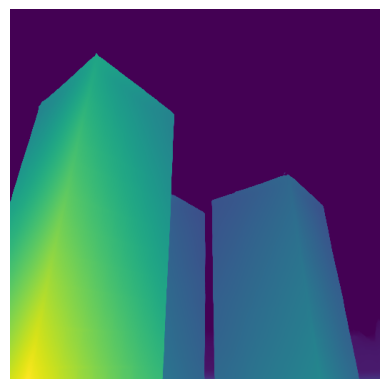

In [36]:
var = 20

img = Image.open(gpath+'/'+names[var]+'_gi.jpg')
input_tensor = transform(img).unsqueeze(0)
with torch.no_grad():
    gen_depth = dmodel(input_tensor.cuda()).cpu()[0]
#gen_depth = gen_depth.numpy()[:,::-1]

with open(spath+'/'+names[var]+'.json', 'r', encoding='utf-8') as file:
    data = json.load(file)
vdir = np.array(data['v'])
theta = data['t']

newdir = np.array([0, (vdir[:2]**2).sum()**0.5, vdir[-1]])

main_masks = []
full_masks = []
for mname in masks_dict[names[var]]:
    ma = Image.open(spath+'/'+mname)
    mask = (transform_mask(ma)[0] > 0.5).numpy()#[:,::-1]
    label_house = int(mname.split('_')[-2])
    label_side = 0 if 'ri' in mname else 1
    full_masks += [(label_house, label_side, mask)]
    er_mask = binary_erosion(mask, iterations=10)
    if er_mask.sum() < 1000:
        continue
    main_masks += [(label_house, label_side, er_mask)]

plt.imshow(gen_depth)
plt.axis('off')
plt.show()

Оптимальные параметры: [158.52607117  44.99985666]
Минимальное значение функции: 0.06519459417426579
Оптимальные параметры: [21.27025815]
Минимальное значение функции: 0.24696293939082042


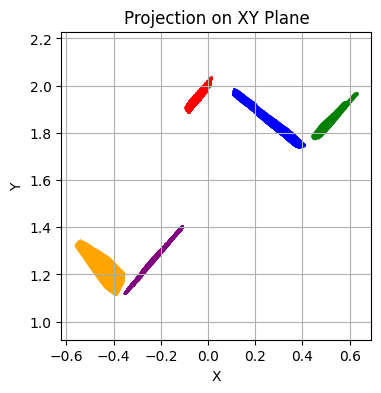

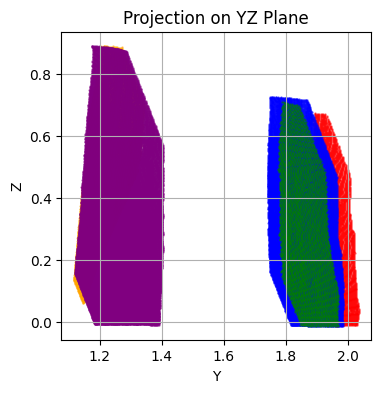

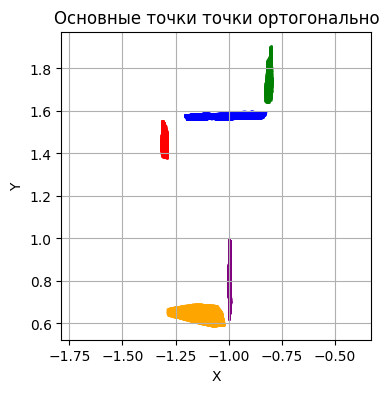

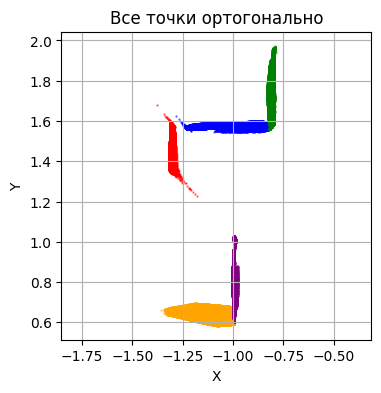

In [55]:
final = get_planar(main_masks, full_masks, gen_depth)

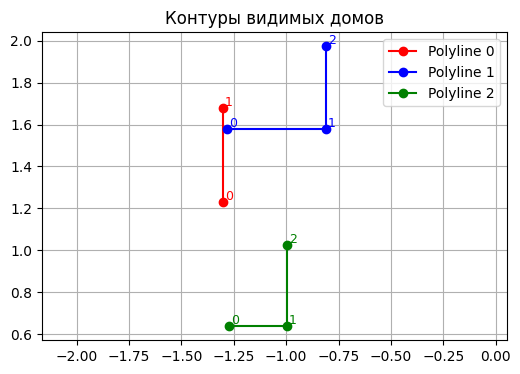

In [135]:
draw_planar(final)

**Пример на реальных данных**

In [140]:
def get_depth_masks(image, masks):
    input_tensor = transform(Image.fromarray(image.numpy())).unsqueeze(0)
    with torch.no_grad():
        real_gen_depth = dmodel(input_tensor.cuda()).cpu()[0]
    
    #plt.imshow(real_gen_depth)
    #plt.show()
    
    real_main_masks = []
    real_full_masks = []
    for i, mdict in enumerate(masks):
        for side, m in mdict.items():
            m = torch.tensor(m)
            mask = torch.tensor(binary_fill_holes(m.numpy()))
            mask = mask.unsqueeze(0).unsqueeze(0).float()
            resized = torch.nn.functional.interpolate(mask, size=(518, 518), mode='nearest')
            mask = resized.squeeze().bool()
            label_house = i
            label_side = 0 if 'ri' in side else 1
            real_full_masks += [(label_house, label_side, mask)]
            er_mask = binary_erosion(mask, iterations=20)
            if er_mask.sum() >= 1000:
                real_main_masks += [(label_house, label_side, er_mask)]
    return real_gen_depth, real_main_masks, real_full_masks

image, masks = torch.load(...)
real_gen_depth, real_main_masks, real_full_masks = get_depth_masks(image, masks)

C:\Users\admin\AppData\Local\Temp\ipykernel_25716\2876716940.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  m = torch.tensor(m)


Оптимальные параметры: [96.83151652 44.99980698]
Минимальное значение функции: 0.0693288341371877
Оптимальные параметры: [22.9406309]
Минимальное значение функции: 0.15949721751712312


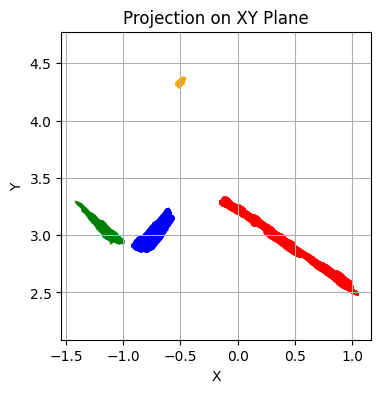

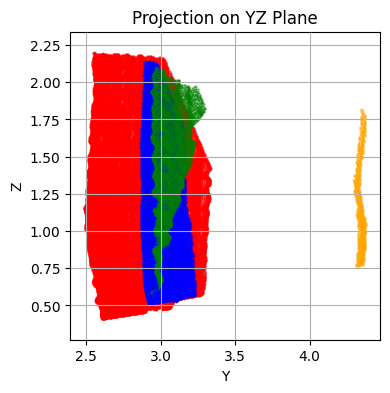

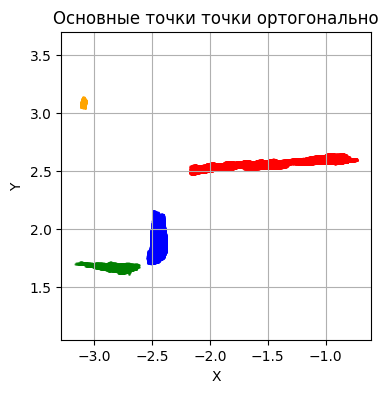

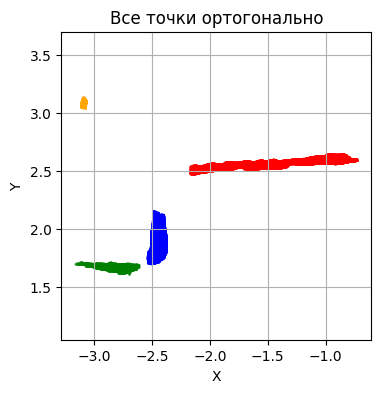

In [15]:
real_final = get_planar(real_main_masks, real_main_masks, real_gen_depth)

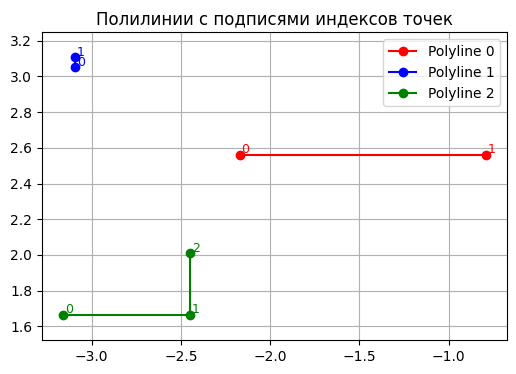

In [12]:
draw_planar(real_final)

In [102]:
photos = torch.load(..., weights_only=False)

In [156]:
def visualize_masks(img, depth, all_masks):
    img_np = np.array(img)
    H, W = img_np.shape[:2]

    # 10 ярких базовых RGB цветов
    base_colors = [
        (255, 0, 0),     # красный
        (0, 255, 0),     # зелёный
        (0, 0, 255),     # синий
        (255, 255, 0),   # жёлтый
        (255, 0, 255),   # пурпурный
        (0, 255, 255),   # голубой
        (255, 128, 0),   # оранжевый
        (128, 0, 255),   # фиолетовый
        (0, 128, 255),   # небесный
        (128, 255, 0)    # салатовый
    ]

    # Создаём пустое изображение с масками
    mask_img = np.zeros((H, W, 3), dtype=np.uint8)

    for i, mask_dict in enumerate(all_masks):
        color = np.array(base_colors[i % len(base_colors)])

        # Применяем 'le' и 'ri' с разной яркостью
        for key, brightness in [('le', 1.0), ('ri', 0.5)]:
            if key in mask_dict:
                mask = mask_dict[key]
                if isinstance(mask, torch.Tensor):
                    mask = mask.cpu().numpy()
                mask = mask.astype(bool)

                color_adjusted = (color * brightness).astype(np.uint8)
                for c in range(3):
                    mask_img[..., c][mask] = color_adjusted[c]

    # Визуализация
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    axs[0].imshow(img_np)
    #axs[0].set_title("Исходное изображение")
    axs[0].axis("off")

    axs[1].imshow(mask_img)
    #axs[1].set_title("Маски объектов")
    axs[1].axis("off")

    axs[2].imshow(depth, cmap='grey')
    #axs[2].set_title("Карты глубины")
    axs[2].axis("off")

    plt.tight_layout()
    global nnn
    plt.savefig(str(nnn)+'_'+str(int(time.time()))+'.png')
    nnn+=1
    plt.show()


def crop_to_square_center(img):
    width, height = img.size
    if width == height:
        return img  # Уже квадратное

    if width > height:
        # Обрезаем по ширине
        delta = width - height
        left = delta // 2
        right = width - (delta - left)
        box = (left, 0, right, height)
    else:
        # Обрезаем по высоте
        delta = height - width
        top = delta // 2
        bottom = height - (delta - top)
        box = (0, top, width, bottom)

    return img.crop(box)

def clean_mask(mask):
    filled = ndimage.binary_fill_holes(mask).astype(np.uint8)
    labeled = label(filled)
    regions = regionprops(labeled)
    if not regions:
        return np.zeros_like(mask)
    largest_region = max(regions, key=lambda r: r.area)
    largest_mask = (labeled == largest_region.label).astype(np.uint8)
    return largest_mask

0


C:\Users\admin\AppData\Local\Temp\ipykernel_25716\2876716940.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  m = torch.tensor(m)


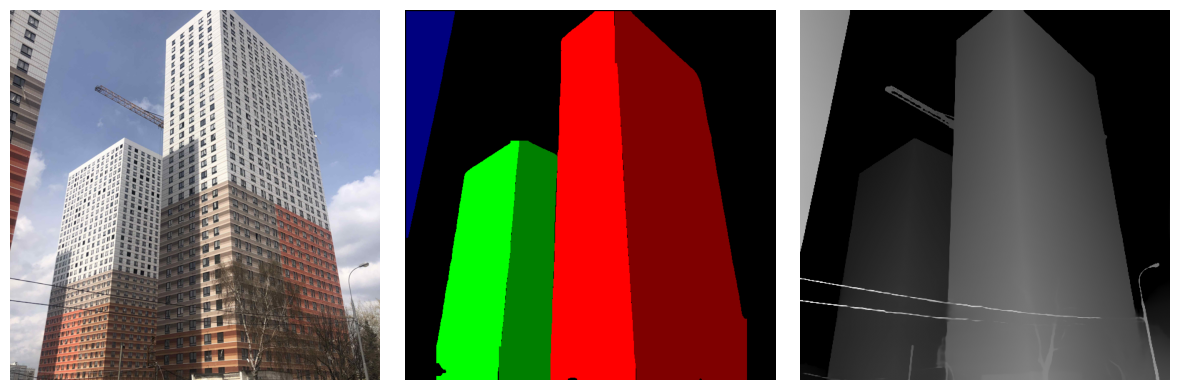

Оптимальные параметры: [98.09116744 44.99943319]
Минимальное значение функции: 0.10945286403165684
Оптимальные параметры: [19.39874083]
Минимальное значение функции: 0.10908076201421979


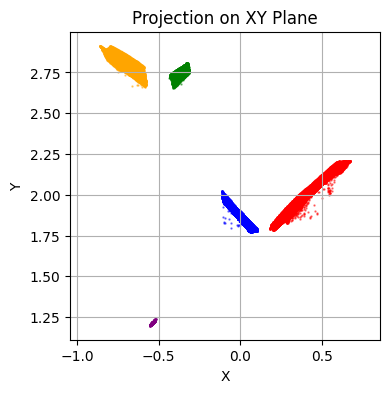

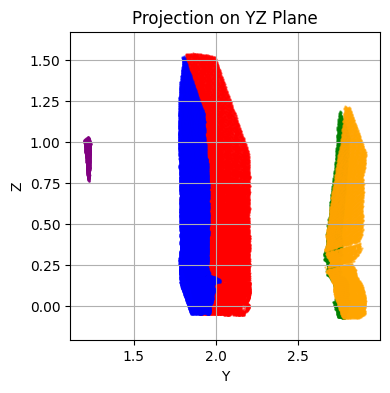

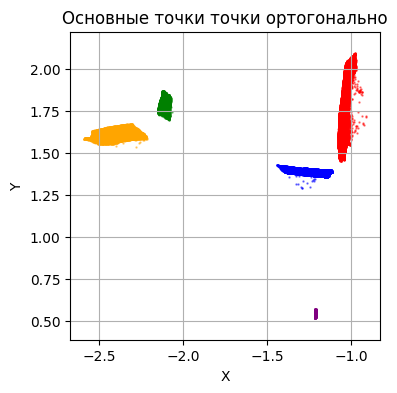

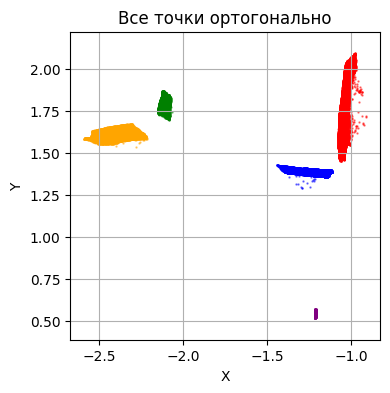

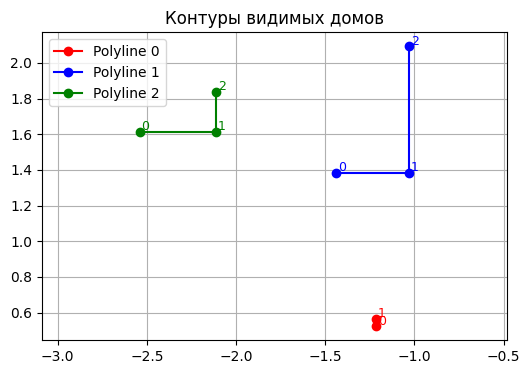

4


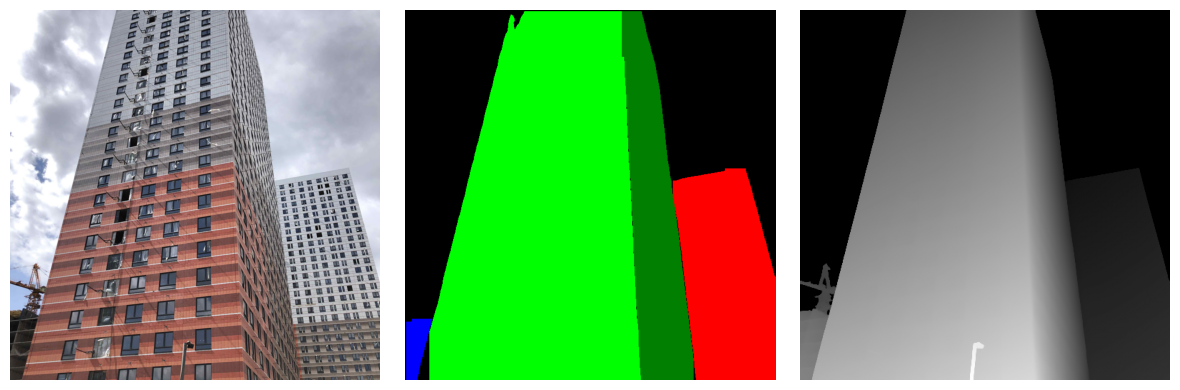

Оптимальные параметры: [128.0241378   42.96608981]
Минимальное значение функции: 0.010544290403328037
Оптимальные параметры: [30.46179558]
Минимальное значение функции: 0.022231606796168174


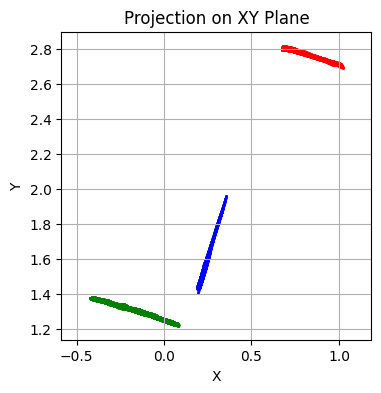

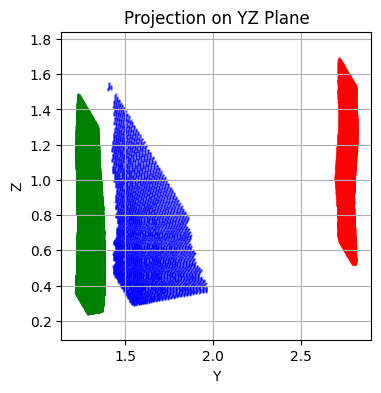

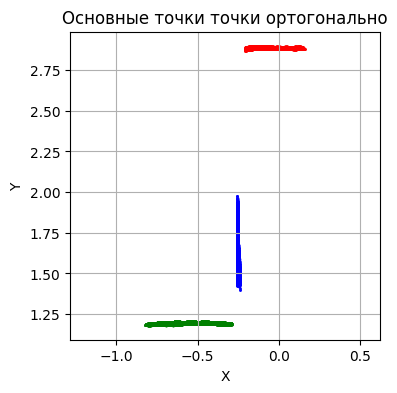

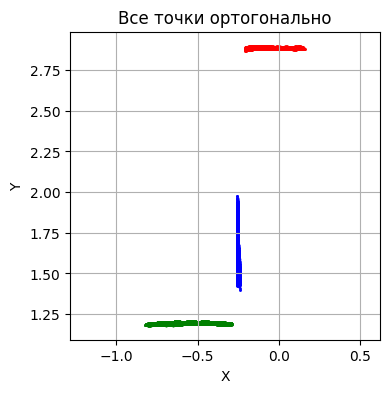

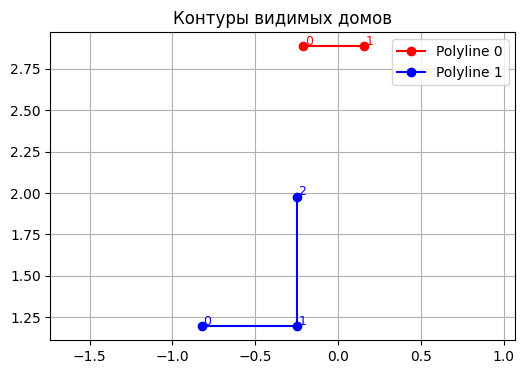

8


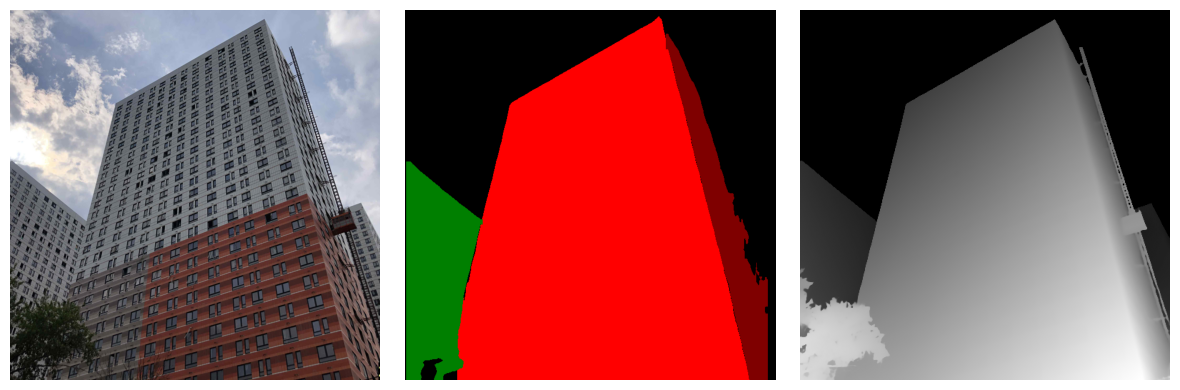

Оптимальные параметры: [249.9999773  21.129808 ]
Минимальное значение функции: 0.6326198630999609
Оптимальные параметры: [51.33520777]
Минимальное значение функции: 0.1480020079156439


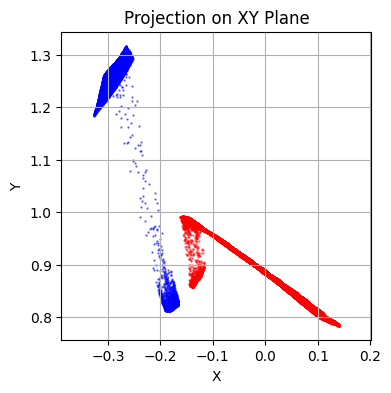

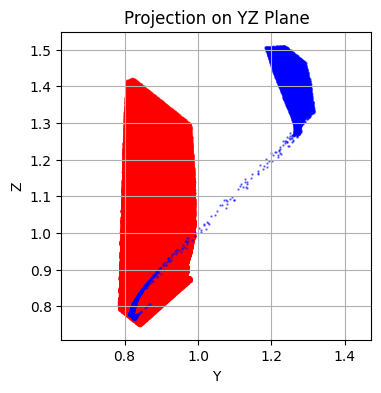

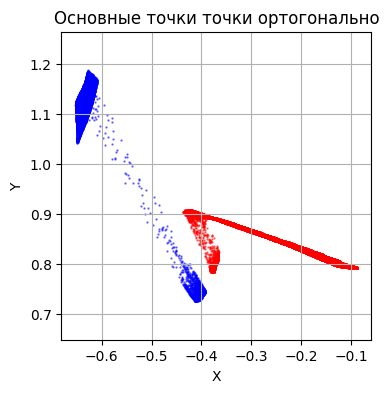

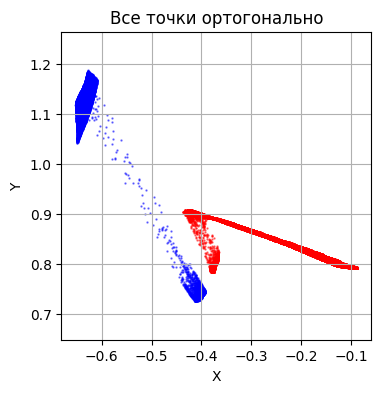

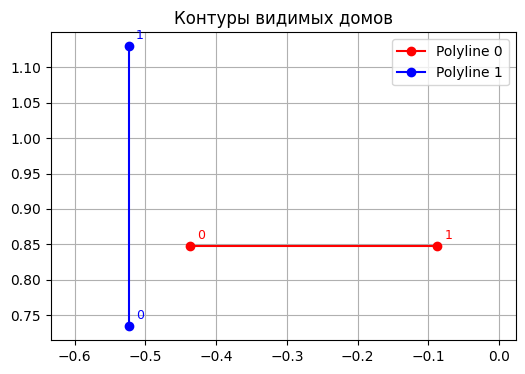

12


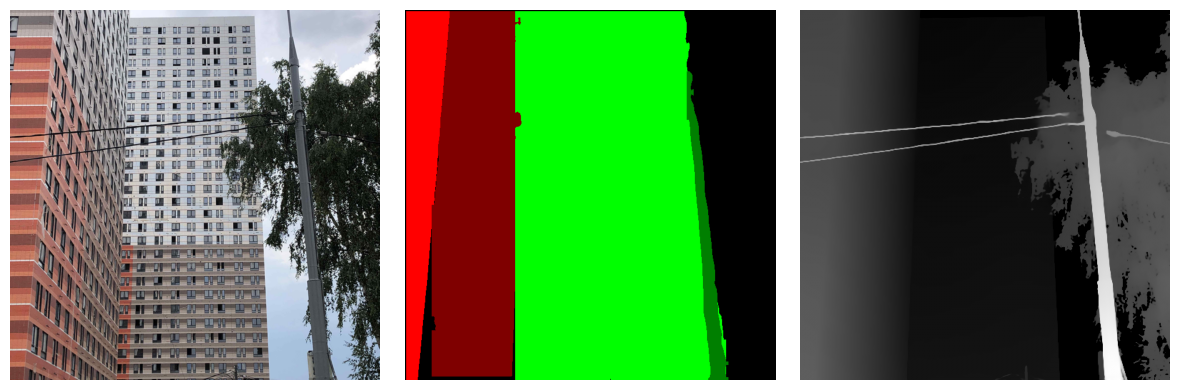

Оптимальные параметры: [249.99911441  14.25447339]
Минимальное значение функции: 0.09319687711282527
Оптимальные параметры: [17.49023726]
Минимальное значение функции: 0.1205015167608666


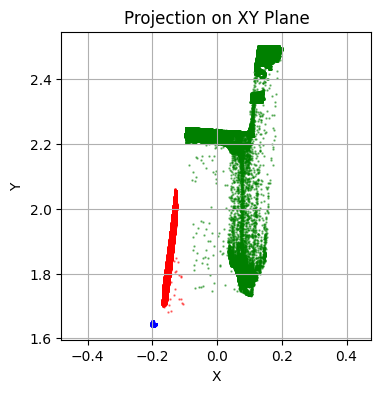

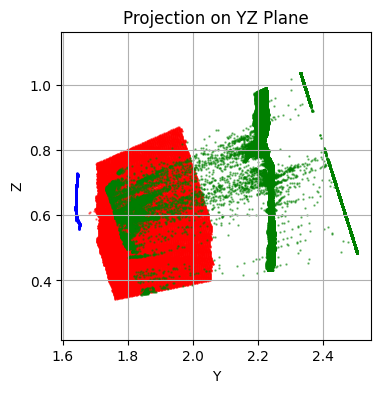

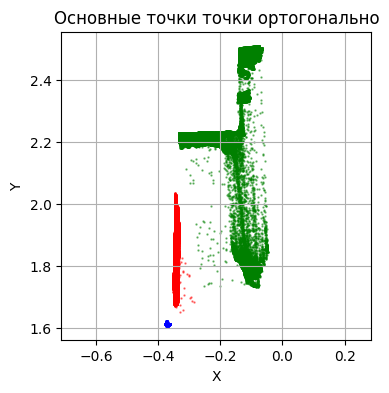

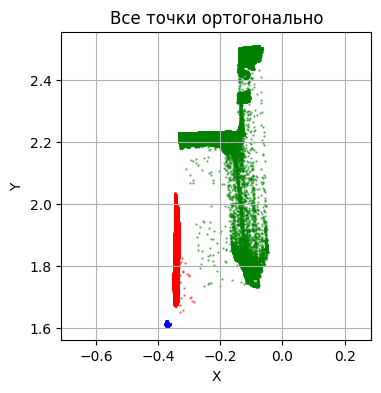

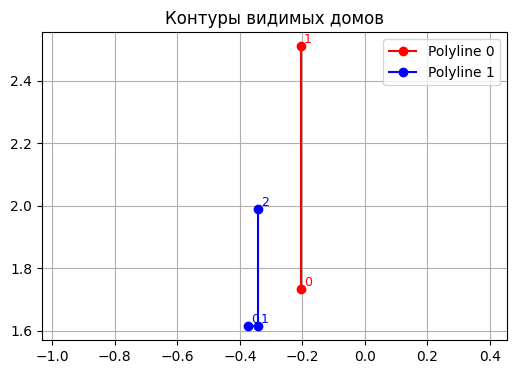

16


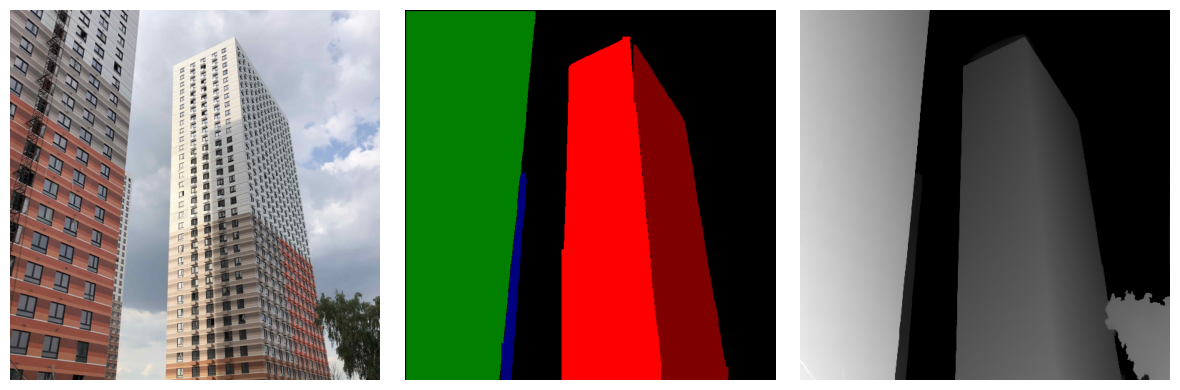

Оптимальные параметры: [90.71458677 47.17333585]
Минимальное значение функции: 0.022392622145462254
Оптимальные параметры: [22.36186993]
Минимальное значение функции: 0.02642619428044579


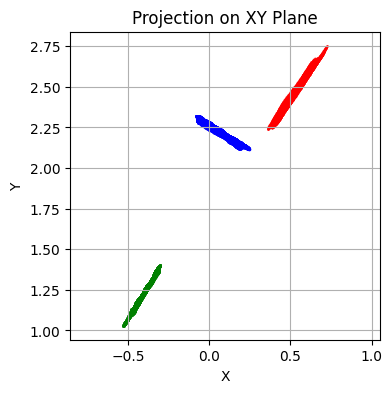

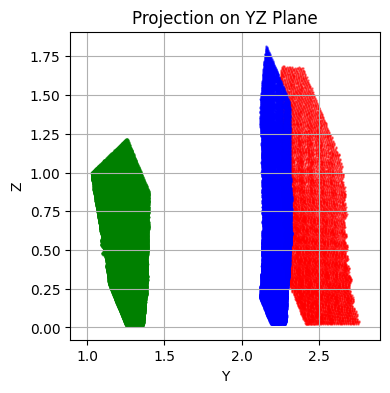

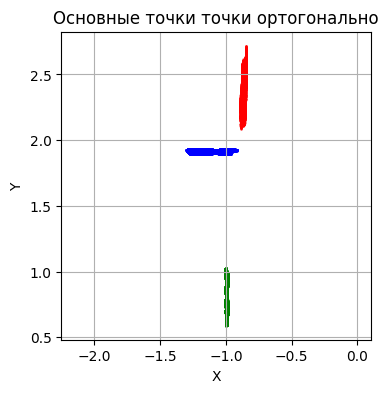

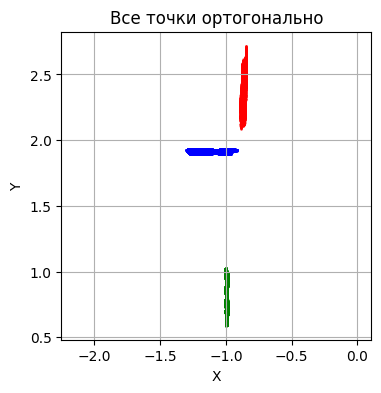

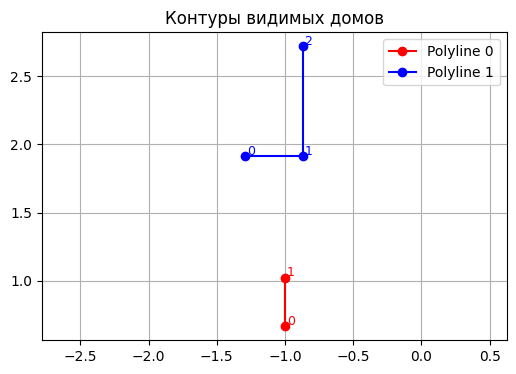

In [162]:
finals = []
nnn=0
for p in photos[:-1]:
    print(nnn)
    image, masks = p
    image = torch.tensor(image)
    real_gen_depth, real_main_masks, real_full_masks = get_depth_masks(image, masks)
    visualize_masks(image, real_gen_depth, masks)
    real_final = get_planar(real_main_masks, real_main_masks, real_gen_depth)
    draw_planar(real_final)
    finals.append(real_final)